In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import itertools
from sklearn.svm import SVR
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error

from utils import Config
from plots import plot_seasonal_decompose, plot_arima_forecast, plot_svm

# Leitura dos dados

In [2]:
config = Config()

In [3]:
df = pd.read_json(config.raw_filepath)

# Pre-Tratamento
- A coluna de data inicialmente é um texto, então foi feita a conversão para datetime
- Foram eliminadas as colunas que não fazem parte da variável alvo

In [4]:
df["data_raw"] = pd.to_datetime(df["rowDate"], format="%d.%m.%Y")
df = df.drop(columns=[
    "rowDate",
    "direction_color",
    "rowDateRaw",
    "rowDateTimestamp",
    "volume",
    "change_precentRaw",
    "last_closeRaw",
    "last_openRaw",
    "last_maxRaw",
    "last_minRaw",
    "last_open",
    "last_max",
    "last_min",
    "volumeRaw",
    "change_precent",
])

In [5]:
df = df.rename(columns={"last_close": "ultimo"})

- As datas se encontram incompletas (não há dados para fins de semana e feriados), foi feito o preenchimento das datas ausentes

In [6]:
all_dates = pd.date_range(start=df["data_raw"].min(), end=df["data_raw"].max())
df_all_dates = pd.DataFrame({'data': all_dates})

In [7]:
df = df.merge(df_all_dates, how="outer", left_on="data_raw", right_on="data")

In [8]:
timeseries = df.set_index("data")["ultimo"].sort_index().interpolate()

# Visualização inicial da série temporal

<Axes: xlabel='data'>

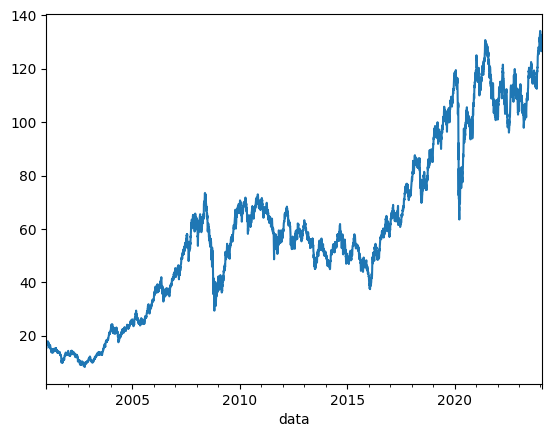

In [9]:
timeseries.plot()

# Visualização da tendência e sazionalidade dos dados
- A partir de 2023 para ser possível visualizar os dados

In [ ]:
plot_seasonal_decompose(timeseries["2023":])

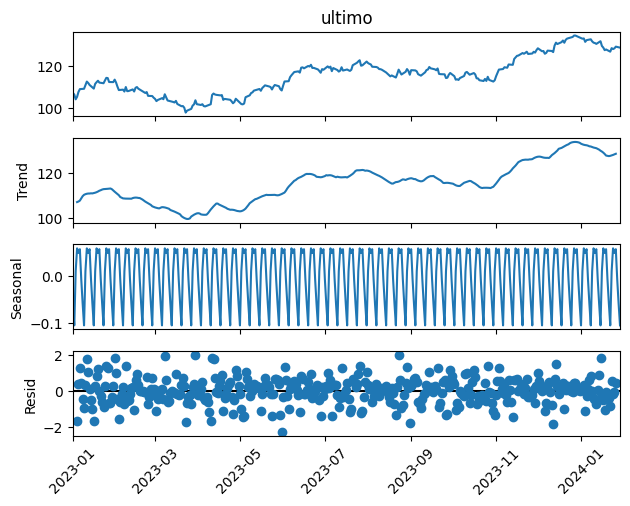

In [12]:
decomposition = sm.tsa.seasonal_decompose(timeseries["2023":], model='additive')
fig = decomposition.plot()
plt.xticks(rotation=45)
plt.show()

# Teste com modelo ARIMA
- Foi feito um teste com diferentes combinações de parametros para encontrar o melhor modelo

In [13]:
p = d = q = range(0, 2)
orders = list(itertools.product(p, d, q))


In [14]:
train_data_arima = timeseries[:-5]

In [15]:
best_model_arima = {"model": None, "aic": None, "order": None}
for order in orders:
    model = ARIMA(train_data_arima, order=order, enforce_invertibility=False, enforce_stationarity=False)
    results = model.fit()
    if best_model_arima["aic"] is None or results.aic < best_model_arima["aic"]:
        best_model_arima["model"] = results
        best_model_arima["aic"] = results.aic
        best_model_arima["order"] = order

/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/rafael/.pyenv/versions/3.9.18/envs

In [16]:
def get_arima_forecast(model, steps):
    forecast = model.get_forecast(steps=steps)

    forecast_values = forecast.predicted_mean
    confidence_intervals = forecast.conf_int()

    return forecast_values, confidence_intervals

In [18]:
forecast_values, confidence_intervals = get_arima_forecast(best_model_arima["model"], 5)

print("Previsões:")
print(forecast_values)

print("\nIntervalos de Confiança:")
print(confidence_intervals)

Previsões:
2024-01-25    127.822411
2024-01-26    127.825807
2024-01-27    127.827606
2024-01-28    127.828559
2024-01-29    127.829064
Freq: D, Name: predicted_mean, dtype: float64

Intervalos de Confiança:
            lower ultimo  upper ultimo
2024-01-25    126.326304    129.318518
2024-01-26    125.677437    129.974178
2024-01-27    125.169058    130.486155
2024-01-28    124.736538    130.920580
2024-01-29    124.354183    131.303945


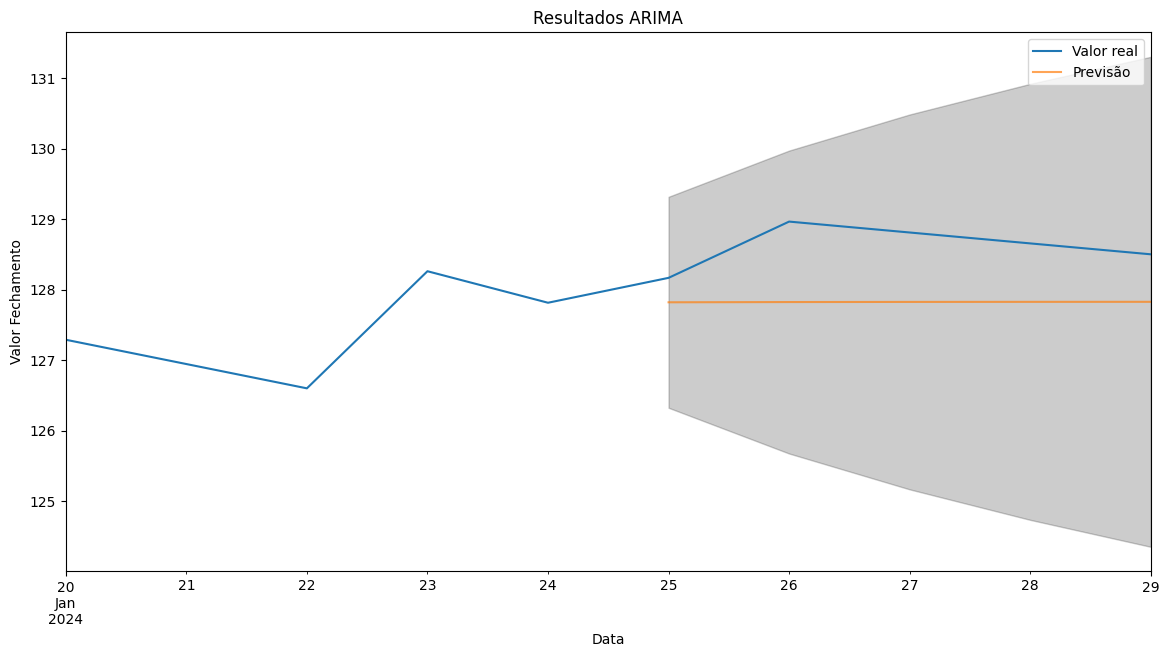

In [19]:
plot_arima_forecast(timeseries.tail(10), forecast_values, confidence_intervals, "Resultados ARIMA")

### Resultados ARIMA

- Com base no gráfico é possível perceber que o modelo não foi eficaz, gerou previsões com uma grande margem de erro

# Teste com modelo SARIMAX

In [22]:
seasonal_orders = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]

In [25]:
best_model_sarimax = {"model": None, "aic": None, "order": None, "seasonal_order": None}
for order in orders:
    for seasonal_order in seasonal_orders:
        model = sm.tsa.statespace.SARIMAX(
            train_data_arima,
            order=order,
            seasonal_order=seasonal_order,
            enforce_invertibility=False,
            enforce_stationarity=False
        )
        results = model.fit()
        if best_model_sarimax["aic"] is None or results.aic < best_model_sarimax["aic"]:
            best_model_sarimax["model"] = results
            best_model_sarimax["aic"] = results.aic
            best_model_sarimax["order"] = order
            best_model_sarimax["seasonal_order"] = seasonal_order


/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.63778D+00    |proj g|=  1.65556D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   1.656D-06   5.638D+00
  F =   5.6377760511086468     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.32069D+00    |proj g|=  7.99622D-01

At iterate    5    f=  5.26760D+00    |proj g|=  7.57533D-02

At iterate   10    f=  5.26627D+00    |proj g|=  4.07116D-02

At iterate   15    f=  5.24448D+00    |proj g|=  2.40441D-01

At iterate   20    f=  5.00005D+00    |proj g|=  2.28596D-01

At iterate   25    f=  4.96777D+00    |proj g|=  5.79353D-05



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     26     51      1     0     0   5.794D-05   4.968D+00
  F =   4.9677740246409856     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.16473D+00    |proj g|=  4.22088D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

 This problem is unconstrained.
/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.16341D+00    |proj g|=  2.96469D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      4      7      1     0     0   3.936D-07   2.163D+00
  F =   2.1630280067811856     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.16448D+00    |proj g|=  5.17059D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     15      1     0     0   5.171D-03   2.164D+00
  F =   2.1644773071648467     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.16485D+00    |proj g|=  4.70996D-02


 This problem is unconstrained.



At iterate    5    f=  2.16413D+00    |proj g|=  2.25529D-01

At iterate   10    f=  2.16410D+00    |proj g|=  2.44806D-03

At iterate   15    f=  2.16410D+00    |proj g|=  1.18088D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     34      1     0     0   1.181D-03   2.164D+00
  F =   2.1641010608955926     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.16320D+00    |proj g|=  4.98575D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   4.986D-06   2.163D+00
  F =   2.1631994344270074     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.16336D+00    |proj g|=  2.85545D-02

At iterate    5    f=  2.16292D+00    |proj g|=  9.03956D-03

At iterate   10    f=  2.16172D+00    |proj g|=  7.03810D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     19      1     0     0   2.842D-06   2.162D+00
  F =   2.1617202554971930     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.30020D+00    |proj g|=  8.35736D-01

At iterate    5    f=  5.26495D+00    |proj g|=  1.08374D-01

At iterate   10    f=  5.26382D+00    |proj g|=  1.76553D-02

At iterate   15    f=  5.03736D+00    |proj g|=  5.92242D-01

At iterate   20    f=  4.95898D+00    |proj g|=  5.79338D-02

At iterate   25    f=  4.95142D+00    |proj g|=  6.26259D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     26     54      1     0     0   

/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.27808D+00    |proj g|=  8.18469D-01

At iterate    5    f=  5.17159D+00    |proj g|=  3.11729D-02

At iterate   10    f=  5.13765D+00    |proj g|=  1.64014D-01

At iterate   15    f=  4.76742D+00    |proj g|=  2.98835D-01

At iterate   20    f=  4.69618D+00    |proj g|=  7.76640D-01

At iterate   25    f=  4.46427D+00    |proj g|=  1.52736D-01

At iterate   30    f=  4.35486D+00    |proj g|=  4.25256D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.40246D+00    |proj g|=  1.56035D+01

At iterate    5    f=  1.80723D+00    |proj g|=  1.50312D-01

At iterate   10    f=  1.79131D+00    |proj g|=  1.75169D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     11     13      1     0     0   7.290D-08   1.791D+00
  F =   1.7913052305643458     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.45573D+00    |proj g|=  1.70245D+01

At iterate    5    f=  1.80234D+00    |proj g|=  1.36852D-01

At iterate   10    f=  1.78316D+00    |proj g|=  4.32290D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     14      1     0     0   1.087D-05   1.783D+00
  F =   1.7831649055701537     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.17796D+00    |proj g|=  9.41568D-01

At iterate    5    f=  4.46923D+00    |proj g|=  1.43880D+00

At iterate   10    f=  2.39928D+00    |proj g|=  2.08530D+01

At iterate   15    f=  1.79710D+00    |proj g|=  8.02617D-01

At iterate   20    f=  1.79146D+00    |proj g|=  3.63076D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     23     51      1     0     0   3.284D-05   1.791D+00
  F =   1.7914573870372799     

CONVERG

/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.17679D+00    |proj g|=  9.39754D-01

At iterate    5    f=  4.52572D+00    |proj g|=  1.31119D+00
  ys=-5.383E-01  -gs= 9.053E-01 BFGS update SKIPPED

At iterate   10    f=  2.25552D+00    |proj g|=  4.22232D+00

At iterate   15    f=  1.88516D+00    |proj g|=  7.77698D-01

At iterate   20    f=  1.78403D+00    |proj g|=  9.37758D-02

At iterate   25    f=  1.78397D+00    |proj g|=  1.09576D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Proj

/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.42576D+00    |proj g|=  1.62329D+01

At iterate    5    f=  1.80223D+00    |proj g|=  1.37460D-01

At iterate   10    f=  1.78261D+00    |proj g|=  3.98005D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     14      1     0     0   3.970D-05   1.783D+00
  F =   1.7826102929371683     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.45491D+00    |proj g|=  1.70000D+01

At iterate    5    f=  1.80315D+00    |proj g|=  1.45962D-01

At iterate   10    f=  1.78254D+00    |proj g|=  5.21545D-03

At iterate   15    f=  1.78157D+00    |proj g|=  1.24484D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     21      1     0     0   3.176D-06   1.781D+00
  F =   1.7814961250160983     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.14920D+00    |proj g|=  2.92127D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1      4      1     0     0   8.646D-08   1.149D+00
  F =   1.1492012276241548     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.1

 This problem is unconstrained.
/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.49654D+00    |proj g|=  9.78083D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      4      1     0     0   6.630D-07   1.497D+00
  F =   1.4965383620692265     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.21468D+00    |proj g|=  2.51862D-01

At iterate    5    f=  1.14986D+00    |proj g|=  3.55479D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      8     15      1     0     0   7.076D-06   1.150D+00
  F =   1.1498579175310404     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.14859D+00    |proj g|=  1.71179D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1      9      1     0     0   1.710D-05   1.149D+00
  F =   1.1485901905218594     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.14851D+00    |proj g|=  1.96176D-03


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      4      8      1     0     0   3.099D-05   1.149D+00
  F =   1.1485126039432203     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.34916D+00    |proj g|=  1.16856D-05


/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     21      1     0     0   1.169D-05   1.349D+00
  F =   1.3491558098346064     

ABNORMAL_TERMINATION_IN_LNSRCH                              


/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.21753D+00    |proj g|=  2.48010D-01

At iterate    5    f=  1.15082D+00    |proj g|=  7.36811D-02

At iterate   10    f=  1.14986D+00    |proj g|=  5.94242D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     31      1     0     0   7.875D-05   1.150D+00
  F =   1.1498578696035899     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.14866D+00    |proj g|=  3.51254D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1      4      1     0     0   9.772D-06   1.149D+00
  F =   1.1486580584854960     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.14796D+00    |proj g|=  3.31052D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      3      5      1     0     0   4.778D-05   1.148D+00
  F =   1.1479641671426506     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.49582D+00    |proj g|=  2.53311D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      2      5      1     0     0   1.041D-05   1.496D+00
  F =   1.4958241997293995     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.27900D+00    |proj g|=  3.99024D-01

At iterate    5    f=  1.15036D+00    |proj g|=  1.62134D-01

At iterate   10    f=  1.14933D+00    |proj g|=  4.27997D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     17      1     0     0   9.770D-06   1.149D+00
  F =   1.1493318160523756     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.14813D+00    |proj g|=  2.48975D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      2      5      1     0     0   2.312D-05   1.148D+00
  F =   1.1481259795046410     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.14796D+00    |proj g|=  5.41740D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      3      6      1     0     0   2.307D-05   1.148D+00
  F =   1.1479647132383299     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.36857D+00    |proj g|=  2.33824D-01


 This problem is unconstrained.



At iterate    5    f=  1.34903D+00    |proj g|=  1.58127D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      9      1     0     0   5.467D-06   1.349D+00
  F =   1.3490276563934178     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.28083D+00    |proj g|=  3.95864D-01

At iterate    5    f=  1.15111D+00    |proj g|=  5.64663D-02

At iterate   10    f=  1.14933D+00    |proj g|=  1.14055D-02

At iterate   15    f=  1.14933D+00    |proj g|=  4.15960D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     31      1     0     0   4.160D-05   1.149D+00
  F =   1.1493317603282645     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.14920D+00    |proj g|=  3.96216D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     21      1     0     0   3.962D-02   1.149D+00
  F =   1.1491970865864998     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.21212D+00    |proj g|=  5.01335D+01


 This problem is unconstrained.



At iterate    5    f=  1.61217D+00    |proj g|=  7.06935D+00

At iterate   10    f=  1.44187D+00    |proj g|=  3.81993D-01

At iterate   15    f=  1.26845D+00    |proj g|=  4.25037D+00

At iterate   20    f=  1.18796D+00    |proj g|=  4.52393D-01

At iterate   25    f=  1.16507D+00    |proj g|=  4.33013D-01

At iterate   30    f=  1.15637D+00    |proj g|=  9.20279D-01

At iterate   35    f=  1.15235D+00    |proj g|=  3.51922D-01

At iterate   40    f=  1.15062D+00    |proj g|=  2.59232D-01

At iterate   45    f=  1.14994D+00    |proj g|=  4.81898D-01

At iterate   50    f=  1.14946D+00    |proj g|=  2.89608D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.46274D+00    |proj g|=  1.99341D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1      5      1     0     0   1.716D-05   1.463D+00
  F =   1.4627377119706408     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.48336D+00    |proj g|=  5.14029D-01

At iterate    5    f=  1.19307D+00    |proj g|=  1.12690D+00

At iterate   10    f=  1.15026D+00    |proj g|=  1.63745D-01

At iterate   15    f=  1.14994D+00    |proj g|=  1.80267D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     38      1     0     0   2.571D-04   1.150D+00
  F =   1.1499429704391539     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.65322D+00    |proj g|=  1.32244D+00

At iterate    5    f=  1.43765D+00    |proj g|=  1.03905D+00

At iterate   10    f=  1.34183D+00    |proj g|=  1.54151D+00

At iterate   15    f=  1.15354D+00    |proj g|=  2.85315D+00

At iterate   20    f=  1.14851D+00    |proj g|=  3.55383D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     22     45      1     0     0   2.810D-02   1.149D+00
  F =   1.1485078766391417     

CONVERG


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.70924D+00    |proj g|=  1.46915D+00


 This problem is unconstrained.



At iterate    5    f=  1.33227D+00    |proj g|=  8.33344D-01

At iterate   10    f=  1.16235D+00    |proj g|=  5.57027D+00

At iterate   15    f=  1.14878D+00    |proj g|=  4.89823D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     42      1     0     0   7.361D-03   1.149D+00
  F =   1.1487806126852624     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.47171D+00    |proj g|=  4.87253D-01

At iterate    5    f=  1.32954D+00    |proj g|=  2.22603D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     11      1     0     0   1.693D-06   1.330D+00
  F =   1.3295359927728707     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.48334D+00    |proj g|=  5.13119D-01

At iterate    5    f=  1.25295D+00    |proj g|=  2.12656D-01

At iterate   10    f=  1.15441D+00    |proj g|=  5.97693D-01

At iterate   15    f=  1.14995D+00    |proj g|=  6.59224D-02

At iterate   20    f=  1.14994D+00    |proj g|=  8.06571D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     45      1     0     0   1.231D-03   1.150D+00
  F =   1.1499429384883004     

CONVERG

/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.14866D+00    |proj g|=  3.72578D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      1     18      1     0     0   3.726D-02   1.149D+00
  F =   1.1486622882028765     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.18973D+00    |proj g|=  4.96229D+01

At iterate    5    f=  1.61376D+00    |proj g|=  6.53905D+00

At iterate   10    f=  1.43829D+00    |proj g|=  3.75369D-01

At iterate   15    f=  1.24699D+00    |proj g|=  2.23086D+00

At iterate   20    f=  1.18202D+00    |proj g|=  3.22279D+00

At iterate   25    f=  1.17117D+00    |proj g|=  8.23809D-01

At iterate   30    f=  1.16428D+00    |proj g|=  7.67276D-01

At iterate   35    f=  1.15260D+00    |proj g|=  5.60371D-01

At iterate   40    f=  1.15143D+00    |proj g|=  4.18616D-01

At iterate   45    f=  1.14996D+00    |proj g|=  1.20800D-01


/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.14929D+00    |proj g|=  2.89460D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     67      1     0     0   2.895D-01   1.149D+00
  F =   1.1492927657268961     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.45783D+00    |proj g|=  5.46253D-03

At iterate    5    f=  1.45781D+00    |proj g|=  3.52607D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5      8      1     0     0   3.526D-08   1.458D+00
  F =   1.4578127080743346     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.47802D+00    |proj g|=  5.03831D-01

At iterate    5    f=  1.18273D+00    |proj g|=  7.83028D-01

At iterate   10    f=  1.15393D+00    |proj g|=  5.38711D-01

At iterate   15    f=  1.15297D+00    |proj g|=  5.16825D-01

At iterate   20    f=  1.14942D+00    |proj g|=  4.12241D-02

At iterate   25    f=  1.14941D+00    |proj g|=  9.38221D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     40      1     0     0   

/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.65233D+00    |proj g|=  1.32120D+00

At iterate    5    f=  1.42123D+00    |proj g|=  8.04409D-01

At iterate   10    f=  1.31758D+00    |proj g|=  9.07599D-01

At iterate   15    f=  1.15983D+00    |proj g|=  4.37248D-01

At iterate   20    f=  1.15082D+00    |proj g|=  2.70318D+00

At iterate   25    f=  1.14805D+00    |proj g|=  8.00768D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     41      1     0     0   

/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.70814D+00    |proj g|=  1.46776D+00

At iterate    5    f=  1.32989D+00    |proj g|=  7.20329D-01

At iterate   10    f=  1.23215D+00    |proj g|=  7.95770D+00

At iterate   15    f=  1.14833D+00    |proj g|=  3.42027D-01

At iterate   20    f=  1.14832D+00    |proj g|=  3.61630D-02

At iterate   25    f=  1.14825D+00    |proj g|=  3.56087D-01



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   30    f=  1.14822D+00    |proj g|=  1.26333D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     56      1     0     0   1.263D-02   1.148D+00
  F =   1.1482180009949812     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.46671D+00    |proj g|=  4.77410D-01


 This problem is unconstrained.



At iterate    5    f=  1.32807D+00    |proj g|=  9.62027D-03

At iterate   10    f=  1.32801D+00    |proj g|=  9.21976D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     14      1     0     0   9.220D-06   1.328D+00
  F =   1.3280113833288743     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.47800D+00    |proj g|=  5.02973D-01

At iterate    5    f=  1.24881D+00    |proj g|=  1.33519D-01

At iterate   10    f=  1.15620D+00    |proj g|=  3.52568D-01

At iterate   15    f=  1.15376D+00    |proj g|=  2.34622D-01

At iterate   20    f=  1.15189D+00    |proj g|=  6.51707D-02

At iterate   25    f=  1.15048D+00    |proj g|=  4.71870D-01

At iterate   30    f=  1.14944D+00    |proj g|=  3.99000D-02

At iterate   35    f=  1.14942D+00    |proj g|=  1.94642D-02

At iterate   40    f=  1.14941D+00    |proj g|=  1.54540D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     42     87      1     0     0   8.337D-04   1.149D+00
  F =   1.1494138969168077     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.14873D+00    |proj g|=  1.71536D-05



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     13      1     0     0   1.714D-05   1.149D+00
  F =   1.1487261512682025     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.14804D+00    |proj g|=  6.83953D-04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      3      6      1     0     0   7.783D-08   1.148D+00
  F =   1.1480394792715176     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.49593D+00    |proj g|=  8.53650D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   8.537D-06   1.496D+00
  F =   1.4959302557002621     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.27904D+00    |proj g|=  3.99003D-01

At iterate    5    f=  1.15046D+00    |proj g|=  1.51222D-01

At iterate   10    f=  1.14942D+00    |proj g|=  1.53903D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     18      1     0     0   1.878D-05   1.149D+00
  F =   1.1494242087108713     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.14804D+00    |proj g|=  6.83704D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      3      6      1     0     0   1.183D-07   1.148D+00
  F =   1.1480393697979101     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.14804D+00    |proj g|=  6.78472D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      3      5      1     0     0   2.594D-05   1.148D+00
  F =   1.1480401876880908     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.36842D+00    |proj g|=  2.33459D-01

At iterate    5    f=  1.34893D+00    |proj g|=  1.57948D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      9      1     0     0   5.472D-06   1.349D+00
  F =   1.3489269619592459     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.28088D+00    |proj g|=  3.95838D-01

At iterate    5    f=  1.15122D+00    |proj g|=  5.63970D-02

At iterate   10    f=  1.14943D+00    |proj g|=  9.25836D-03

At iterate   15    f=  1.14942D+00    |proj g|=  2.48261D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     27      1     0     0   4.435D-06   1.149D+00
  F =   1.1494241753241763     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.14848D+00    |proj g|=  1.46794D-03

At iterate    5    f=  1.14848D+00    |proj g|=  1.62976D-03

At iterate   10    f=  1.14848D+00    |proj g|=  2.87397D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     14      1     0     0   2.874D-06   1.148D+00
  F =   1.1484793072975417     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.14779D+00    |proj g|=  1.37646D-03

At iterate    5    f=  1.14779D+00    |proj g|=  7.79876D-05

At iterate   10    f=  1.14779D+00    |proj g|=  1.83157D-03

At iterate   15    f=  1.14778D+00    |proj g|=  2.40390D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     20      1     0     0   8.347D-06   1.148D+00
  F =   1.1477829065695107     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.49682D+00    |proj g|=  3.91554D-02

At iterate    5    f=  1.49604D+00    |proj g|=  1.50993D-02

At iterate   10    f=  1.49568D+00    |proj g|=  1.50201D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     17      1     0     0   2.845D-06   1.496D+00
  F =   1.4956832863643381     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.27899D+00    |proj g|=  3.98631D-01

At iterate    5    f=  1.14917D+00    |proj g|=  2.81491D-03

At iterate   10    f=  1.14917D+00    |proj g|=  1.11788D-03

At iterate   15    f=  1.14916D+00    |proj g|=  1.13865D-02

At iterate   20    f=  1.14915D+00    |proj g|=  1.35707D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     28      1     0     0   9.989D-06   1.149D+00
  F =   1.1491467162384243     

CONVERG

/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.14789D+00    |proj g|=  1.35498D-03

At iterate    5    f=  1.14789D+00    |proj g|=  1.42789D-04

At iterate   10    f=  1.14788D+00    |proj g|=  8.30857D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     17      1     0     0   2.794D-06   1.148D+00
  F =   1.1478803380428995     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.14779D+00    |proj g|=  1.62949D-03

At iterate    5    f=  1.14779D+00    |proj g|=  3.60787D-04

At iterate   10    f=  1.14778D+00    |proj g|=  1.50473D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     16      1     0     0   2.195D-05   1.148D+00
  F =   1.1477828537219974     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.36883D+00    |proj g|=  2.32590D-01

At iterate    5    f=  1.34906D+00    |proj g|=  4.91237D-04

At iterate   10    f=  1.34901D+00    |proj g|=  1.43803D-02

At iterate   15    f=  1.34892D+00    |proj g|=  9.59645D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     22      1     0     0   2.643D-06   1.349D+00
  F =   1.3489200811761801     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.28082D+00    |proj g|=  3.95458D-01


 This problem is unconstrained.



At iterate    5    f=  1.15096D+00    |proj g|=  5.63993D-02

At iterate   10    f=  1.14919D+00    |proj g|=  2.92621D-02

At iterate   15    f=  1.14917D+00    |proj g|=  2.03601D-04

At iterate   20    f=  1.14916D+00    |proj g|=  2.84775D-03

At iterate   25    f=  1.14915D+00    |proj g|=  1.29091D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     39      1     0     0   7.211D-06   1.149D+00
  F =   1.1491466306602136     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


In [26]:
forecast_values, confidence_intervals = get_arima_forecast(best_model_sarimax["model"], 5)

print("Previsões:")
print(forecast_values)

print("\nIntervalos de Confiança:")
print(confidence_intervals)

Previsões:
2024-01-25    127.827642
2024-01-26    127.829607
2024-01-27    127.832942
2024-01-28    127.835438
2024-01-29    127.837483
Freq: D, Name: predicted_mean, dtype: float64

Intervalos de Confiança:
            lower ultimo  upper ultimo
2024-01-25    126.331155    129.324130
2024-01-26    125.680823    129.978391
2024-01-27    125.173781    130.492103
2024-01-28    124.742480    130.928397
2024-01-29    124.361273    131.313693


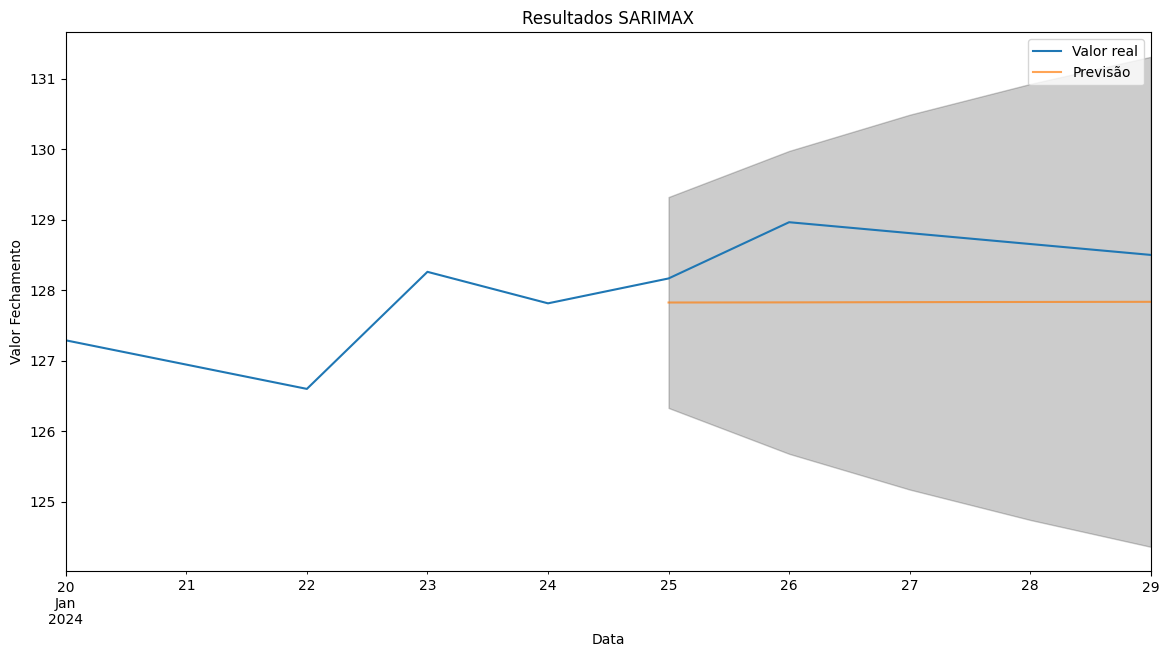

In [27]:
plot_arima_forecast(timeseries.tail(10), forecast_values, confidence_intervals, "Resultados SARIMAX")

### Resultados SARIMAX

- Com base no gráfico é possível perceber que o modelo obteve resultados similares ao anterior

# Modelo SVM

In [39]:
# definição de steps para o modelo identificar uma janela de 7 valores
timesteps=7

In [40]:
# definição do dataset de treino e teste, 80% teste 20% treino
train_size = int(len(timeseries) * 0.8)
train, test = timeseries[:train_size], timeseries[train_size:]

In [41]:
train_data = train.values
test_data = test.values

In [42]:
def aggregate_data_in_timesteps(data, timesteps):
    return np.array([[j for j in data[i:i+timesteps]] for i in range(0,len(data)-timesteps+1)])

In [43]:
# Agrega os dados de treino
train_data_timesteps = aggregate_data_in_timesteps(train_data, timesteps)
train_data_timesteps.shape

(6741, 7)

In [44]:
test_data_timesteps = aggregate_data_in_timesteps(test_data, timesteps)
test_data_timesteps.shape

(1681, 7)

Separação entre dados de features e variável alvo

In [45]:
def split_x_y(data, timesteps):
    return data[:,:timesteps-1], data[:,[timesteps-1]]

In [46]:
x_train, y_train = split_x_y(train_data_timesteps, timesteps)
x_train.shape, y_train.shape

((6741, 6), (6741, 1))

In [47]:
x_test, y_test = split_x_y(test_data_timesteps, timesteps)
x_test.shape, y_test.shape

((1681, 6), (1681, 1))

In [48]:
# Treinamento do modelo
svm_model = SVR(kernel='linear')
svm_model.fit(x_train, y_train)

/home/rafael/.pyenv/versions/3.9.18/envs/venv-pos/lib/python3.9/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(kernel='linear')

In [49]:
# Previsões de teste
svm_predictions = svm_model.predict(x_test).reshape(-1,1)

In [50]:
# Cria as timestamps para plotar no gráfico
train_timestamps = timeseries[:train_size].index[timesteps-1:]
test_timestamps = timeseries[train_size:].index[timesteps-1:]

In [ ]:
plot_svm(test_timestamps, y_test, svm_predictions)

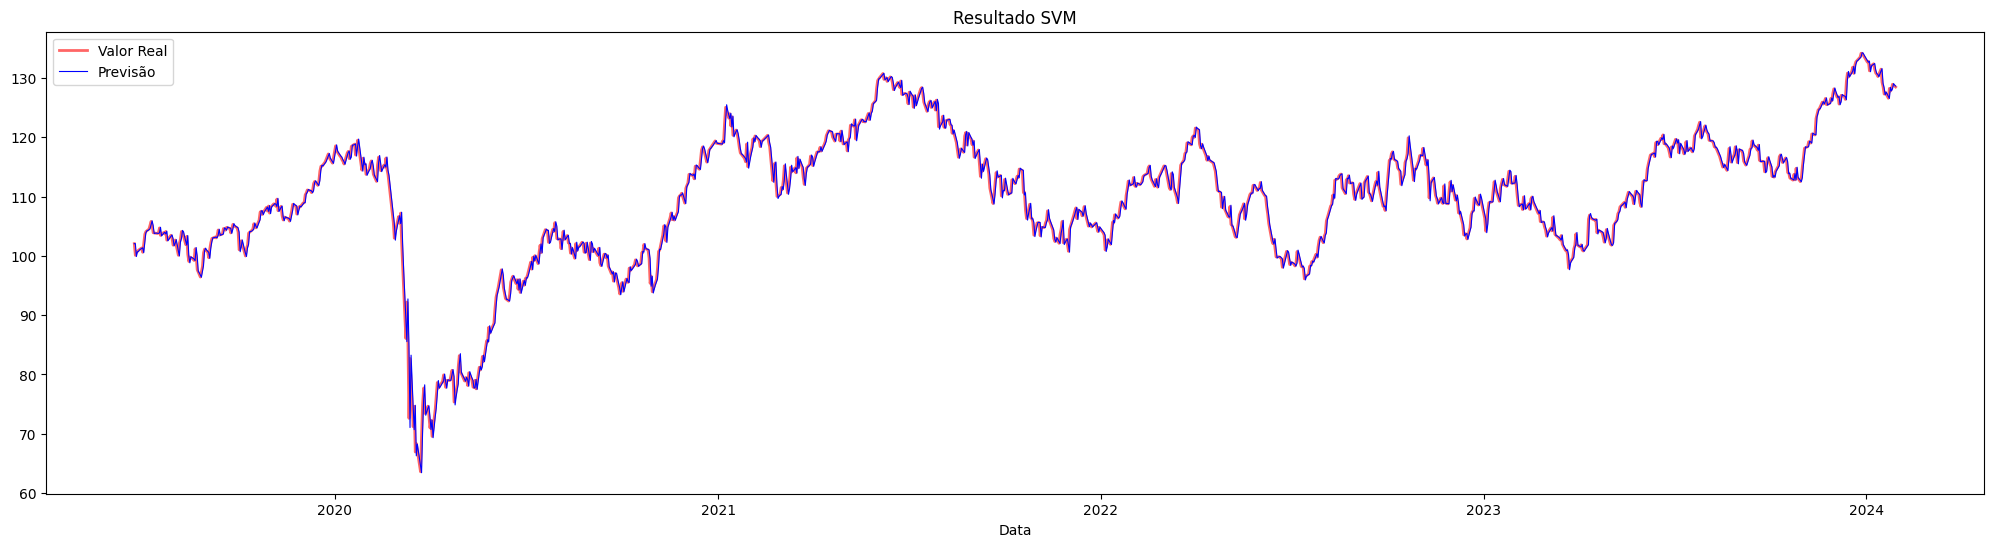

In [51]:
plt.figure(figsize=(25,6))
plt.plot(test_timestamps, y_test, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(test_timestamps, svm_predictions, color = 'blue', linewidth=0.8)
plt.legend(['Valor Real','Previsão'])
plt.xlabel('Data')
plt.title("Resultado SVM")
plt.show()

In [56]:
# Suponha que 'y_test' são os valores reais e 'previsoes' são as previsões do seu modelo
mape = mean_absolute_percentage_error(y_test, svm_predictions)

# A média dos erros fornece a margem de erro média
margem_de_erro_media = mape * 100
f"{margem_de_erro_media:.2f}%"

'0.76%'

### Resutado
- O modelo SVM será utilizado, pois conseguiu boas previsões com uma margem de erro média de 0.76%